In [1]:
import os, yaml, sys
import numpy as np
import torch
import h5py
from torchvision import models
from scipy.spatial.distance import squareform
import timm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import create_RDM, get_device
from image_processing.utils import get_usual_transform, load_torchvision_model, map_anns_names, load_timm_model
from general_utils.utils import get_device, decode_matlab_strings, subsample_RDM
device = get_device()

09:13:43 - device being used: mps


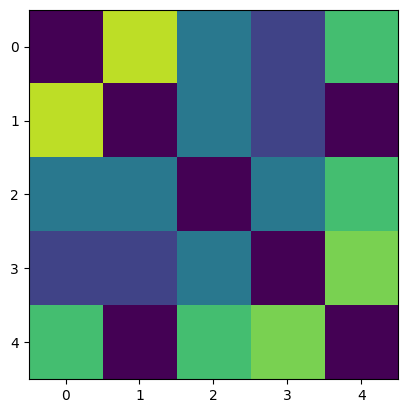

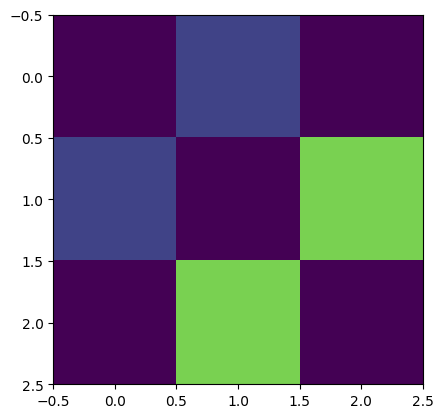

In [2]:
a = np.random.randint(size=10,  low=0, high=10)
plt.imshow(squareform(a))
plt.clim([0,10])
plt.figure()
plt.imshow(subsample_RDM(squareform(a),[1,3, 4] ))
plt.clim([0,10])

In [3]:
monkey_name = "paul"
allimgs_path = f"{paths['livingstone_lab']}/tiziano/data/{monkey_name}_allimages230204.mat"
rasters_path = f"{paths['livingstone_lab']}/tiziano/data/{monkey_name}_natrasters230204.mat"
with h5py.File(allimgs_path, "r") as f:
    refs = f["allimages"][:]      # shape (N, 1) of object refs
    image_names = decode_matlab_strings(f, refs)
    image_names = list(dict.fromkeys(image_names)) 

In [4]:
# from PIL import Image
# plt.imshow(Image.open("/Volumes/LivingstoneLab/Stimuli/fewer_occlusion/fruitparfait/fruitparfait_014.jpg"))

In [5]:
transform = get_usual_transform(resize_size=384, normalize=False)

dataset = ImageFolder(
    root=f"{paths['livingstone_lab']}/Stimuli/fewer_occlusion/",
    transform=transform,
    is_valid_file=lambda x: not x.endswith("Thumbs.db"), 
    allow_empty=True, 
)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [6]:
img, label = dataset[0]
path, label_from_samples = dataset.samples[0]

filename = os.path.basename(path)

print("Full path:", path)
print("Filename:", filename)
print("Class index:", label)
print("Class name:", dataset.classes[label])

Full path: /Users/tizianocausin/livingstone_lab_local/Stimuli/fewer_occlusion/BigAnimate/BigAnimate_01.jpg
Filename: BigAnimate_01.jpg
Class index: 0
Class name: BigAnimate


BigAnimate


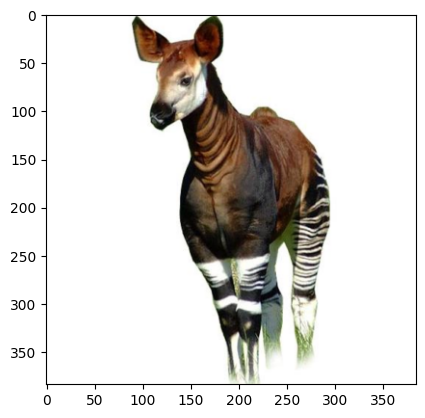

In [36]:
plt.imshow(dataset[0][0].permute(1,2,0))
print(dataset.classes[dataset[0][1]])

In [ ]:
model = load_timm_model("vit_l_16", 384,device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplac

In [30]:
feature_extractor = create_feature_extractor(model, return_nodes=["blocks.18.mlp.fc2"]).to(device)
all_feats = []
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(dataloader):
        feats =feature_extractor(images.to(device))["blocks.18.mlp.fc2"]
        feats = feats.reshape(feats.size(0), -1).cpu().numpy()
        all_feats.append(feats)
        print(feats.shape)
        if batch_idx == 2:
            break


(2, 590848)
(2, 590848)
(2, 590848)


## Feature extraction
- 1. create dataset and transform
- 2. loop through dataset
- 3. create a list to keep the indices of presentation of the images (see presentation order and mapping)
- 4. compute RDM and store it
- 5. do PCA and store it
- 6. project features
- 7. map ANNs' presentation order onto neurons' presentation order (so that then we have everything ordered)
- 8. compute RDM and store it
- 9. store dimensionality reduced features and PCA object

